In [2]:
import pandas as pd
import numpy as np


df = pd.read_csv('../data/interim/df_ready_for_cleaning.csv')

print("Données chargées pour le nettoyage.")
print(f"Dimensions : {df.shape}")
df.head()

Données chargées pour le nettoyage.
Dimensions : (30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,TARGET
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
fill = (df['EDUCATION'] == 0) | (df['EDUCATION'] == 5) | (df['EDUCATION'] == 6)
df.loc[fill, 'EDUCATION'] = 4

fill = (df['MARRIAGE'] == 0)
df.loc[fill, 'MARRIAGE'] = 3

print("Distribution après nettoyage EDUCATION :")
print(df['EDUCATION'].value_counts())
print("\nDistribution après nettoyage MARRIAGE :")
print(df['MARRIAGE'].value_counts())

Distribution après nettoyage EDUCATION :
EDUCATION
2    14030
1    10585
3     4917
4      468
Name: count, dtype: int64

Distribution après nettoyage MARRIAGE :
MARRIAGE
2    15964
1    13659
3      377
Name: count, dtype: int64


In [4]:
print("Début du Feature Engineering...")

pay_status_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
bill_amt_cols   = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
pay_amt_cols    = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

df['SD_COUNT'] = df[pay_status_cols].apply(lambda x: (x >= 2).sum(), axis=1)

total_bill = df[bill_amt_cols].sum(axis=1)
total_pay  = df[pay_amt_cols].sum(axis=1)
df['TOTAL_PAY_RATIO'] = total_pay / (total_bill + 1)

df['UTILIZATION_RATIO'] = df['BILL_AMT1'] / df['LIMIT_BAL']

df['TOTAL_PAY_RATIO'] = df['TOTAL_PAY_RATIO'].clip(upper=100)

print("Feature Engineering terminé.")
print("-" * 30)
print(df[['SD_COUNT', 'TOTAL_PAY_RATIO', 'UTILIZATION_RATIO']].describe())
print("-" * 30)
print("Aperçu des 5 premières lignes :")
df[['TARGET', 'SD_COUNT', 'TOTAL_PAY_RATIO', 'UTILIZATION_RATIO']].head()


Début du Feature Engineering...
Feature Engineering terminé.
------------------------------
           SD_COUNT  TOTAL_PAY_RATIO  UTILIZATION_RATIO
count  30000.000000     30000.000000       30000.000000
mean       0.710133         0.589228           0.423771
std        1.464712         7.739079           0.411462
min        0.000000      -589.000000          -0.619892
25%        0.000000         0.041073           0.022032
50%        0.000000         0.086192           0.313994
75%        1.000000         0.598218           0.829843
max        6.000000       100.000000           6.455300
------------------------------
Aperçu des 5 premières lignes :


,TARGET,SD_COUNT,TOTAL_PAY_RATIO,UTILIZATION_RATIO
0,1,2,0.089422,0.195650
1,1,2,0.292774,0.022350
2,0,0,0.108387,0.324878
3,0,0,0.036259,0.939800
4,0,0,0.540049,0.172340


In [6]:

df['TOTAL_PAY_RATIO'] = df[pay_amt_cols].sum(axis=1) / (df[bill_amt_cols].sum(axis=1) + 1)


mask_negative_bill = df[bill_amt_cols].sum(axis=1) <= 0
df.loc[mask_negative_bill, 'TOTAL_PAY_RATIO'] = 1.0

df['TOTAL_PAY_RATIO'] = df['TOTAL_PAY_RATIO'].clip(lower=0, upper=10) # 10 signifie qu'il a payé 10x sa dette, c'est suffisant comme info max.

df['UTILIZATION_RATIO'] = df['UTILIZATION_RATIO'].clip(lower=0)

print("Correction appliquée. Vérification des stats :")
print(df[['TOTAL_PAY_RATIO', 'UTILIZATION_RATIO']].describe())

Correction appliquée. Vérification des stats :
       TOTAL_PAY_RATIO  UTILIZATION_RATIO
count     30000.000000       30000.000000
mean          0.423786           0.423938
std           0.773318           0.411252
min           0.000000           0.000000
25%           0.043163           0.022032
50%           0.106450           0.313994
75%           0.718472           0.829843
max          10.000000           6.455300


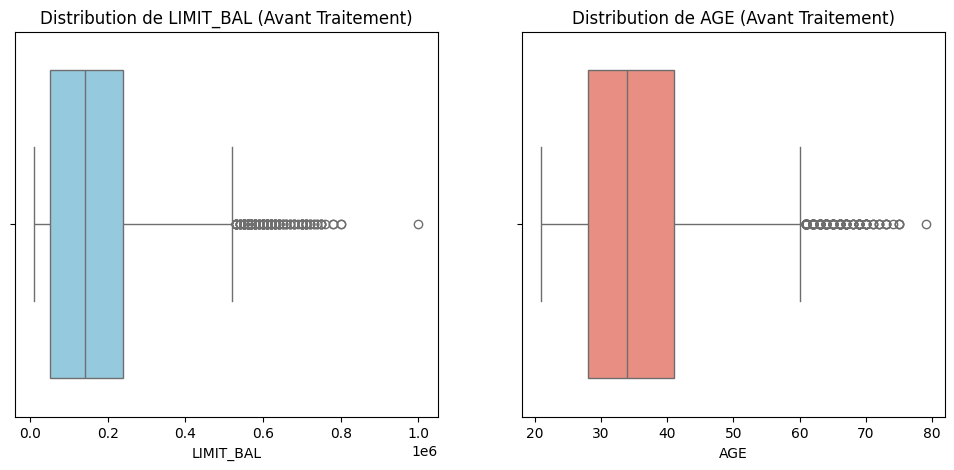

Max LIMIT_BAL: 1000000.0
Max AGE: 79


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualisation des Outliers potentiels
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(x=df['LIMIT_BAL'], ax=axes[0], color='skyblue')
axes[0].set_title('Distribution de LIMIT_BAL (Avant Traitement)')

sns.boxplot(x=df['AGE'], ax=axes[1], color='salmon')
axes[1].set_title('Distribution de AGE (Avant Traitement)')

plt.show()

# Affichage des valeurs max pour voir l'étendue
print("Max LIMIT_BAL:", df['LIMIT_BAL'].max())
print("Max AGE:", df['AGE'].max())

In [8]:

def cap_outliers(series, percentile=0.99):
    limit = series.quantile(percentile)
    # On remplace tout ce qui dépasse la limite par la limite elle-même
    return series.clip(upper=limit)

print("Traitement des Outliers (Capping au 99ème percentile)...")

# 1. LIMIT_BAL : On ne veut pas que les ultra-riches écrasent l'échelle
df['LIMIT_BAL'] = cap_outliers(df['LIMIT_BAL'])

# 2. BILL_AMT : Les montants de factures peuvent être géants
for col in bill_amt_cols:
    df[col] = cap_outliers(df[col])

# 3. PAY_AMT : Les remboursements aussi
for col in pay_amt_cols:
    df[col] = cap_outliers(df[col])

# Note : On ne touche PAS à l'AGE (sauf si > 100) ni aux statuts PAY (catégoriels)
print("Outliers traités. Les 'Baleines' sont ramenées à la limite du 99% sans être supprimées.")

# Vérification rapide
print("Nouveau Max LIMIT_BAL:", df['LIMIT_BAL'].max())

Traitement des Outliers (Capping au 99ème percentile)...
Outliers traités. Les 'Baleines' sont ramenées à la limite du 99% sans être supprimées.
Nouveau Max LIMIT_BAL: 500000.0


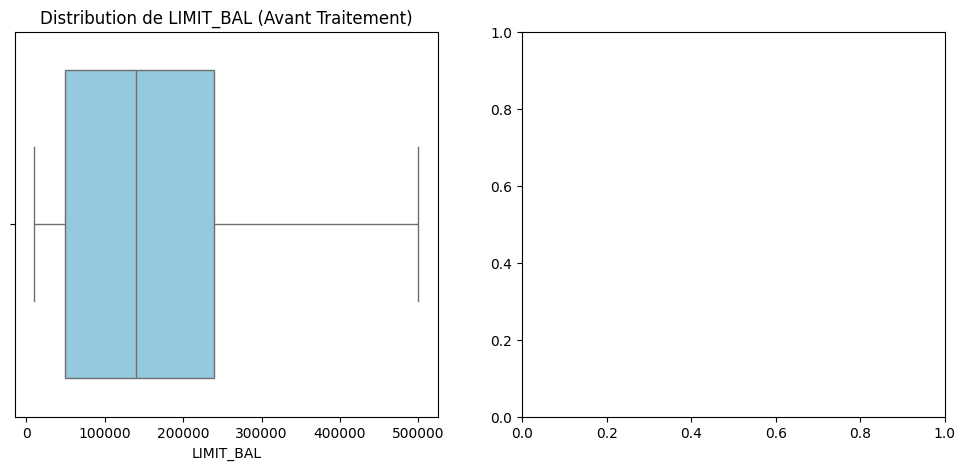

Max LIMIT_BAL: 500000.0
Max AGE: 79


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualisation des Outliers potentiels
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(x=df['LIMIT_BAL'], ax=axes[0], color='skyblue')
axes[0].set_title('Distribution de LIMIT_BAL (Avant Traitement)')

plt.show()

# Affichage des valeurs max pour voir l'étendue
print("Max LIMIT_BAL:", df['LIMIT_BAL'].max())
print("Max AGE:", df['AGE'].max())

In [10]:

output_path = '../data/processed/df_cleaned_engineered.csv'
df.to_csv(output_path, index=False)

print(f"Dataset propre sauvegardé avec succès : {output_path}")
print(f"Dimensions finales : {df.shape}")

Dataset propre sauvegardé avec succès : ../data/processed/df_cleaned_engineered.csv
Dimensions finales : (30000, 27)
